In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm.notebook import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Rock Paper Scissors actions
action_to_descr = 'RPS'
n_act = len(action_to_descr)

In [3]:
def rewards(a1, a2):
    """Rock paper scissors game."""
    a1 = action_to_descr[a1]
    a2 = action_to_descr[a2]
    if a1 == a2:
        return (0, 0)
    outcomes = {'RP': (-1, 1),
     'RS': (1, -1),
     'PS': (-1, 1),
     
    }
    a1a2 = a1 + a2
    a2a1 = a1a2[::-1]
    if a1a2 in outcomes:
        return outcomes[a1a2]
    elif a2a1 in outcomes:
        return outcomes[a2a1][::-1]
    else:
        raise Exception("Unkown action pair %s" % a1a2)

## All outcomes (sanity check)

In [4]:
for a1 in range(n_act):
    for a2 in range(n_act):
        r = rewards(a1, a2)
        ad1 = action_to_descr[a1]
        ad2 = action_to_descr[a2]
        descr = ""
        if r[0] > r[1]:
            descr = "%s wins" % ad1
        elif r[1] > r[0]:
            descr = "%s loses" % ad1
        else:
            descr = "tie"
        print("%s vs %s => %s" % (ad1, ad2, descr))

R vs R => tie
R vs P => R loses
R vs S => R wins
P vs R => P wins
P vs P => tie
P vs S => P loses
S vs R => S loses
S vs P => S wins
S vs S => tie


## Agent and environment

In [5]:
class Trainer(object):
    def __init__(self, agent):
        self.agent = agent
        self.optimizer = tf.keras.optimizers.Adam(1e-1)
        
    def train(self):
        loss = 0
        if not self.agent.train_data:
            return

        #@tf.function 
        def get_reinforce_loss(data, model):
            loss = 0.0
            for (xi, a, r, opponent) in data:
                loss -= r * tf.math.log(model(np.array([xi]))[0][a])
            loss /= len(data)
            return loss

        with tf.GradientTape() as tape:
            loss = get_reinforce_loss(self.agent.train_data, self.agent.model)

        self.agent.train_data = []
        grads = tape.gradient(loss, self.agent.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.agent.model.trainable_variables))
        
class RPCAgent(object):
    """Rock Paper Scissors agent."""
    def __init__(self, noise_dim, identity=None, train_every=10):
        self.noise_dim = noise_dim
        self.identity = identity
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_shape=(self.noise_dim,), activation='relu'),
            tf.keras.layers.Dense(n_act, activation=None),
          tf.keras.layers.Softmax(),
        ])
        self.trainer = Trainer(agent=self)
        self.do_train = True
        
        self.data = []
        self.train_data = []
        
        self.reward_by_opponent = {}
        self.train_every = train_every
        
    def step(self, xi):
        p = self.model(np.array([xi]))[0].numpy()
        p = p / np.sum(p)
        return np.random.choice(range(n_act), p=p)

    def register_episode(self, h, opponent=None):
        self.data.append(deepcopy(list(h)) + [opponent])
        self.train_data.append(self.data[-1])
        if opponent not in self.reward_by_opponent:
            self.reward_by_opponent[opponent] = []
        self.reward_by_opponent[opponent].append(h[-1])
        self._train()
        
    def _train(self):
        if not self.do_train:
            return
        if len(self.data) % self.train_every == 0:
            self.trainer.train()
    
    def __repr__(self):
        opponents = np.unique([x[-1].identity for x in self.data])
        return "<Agent id=%d wisdom=%d opponents=%d>" % (self.identity, len(self.data),
                                            len(opponents))

class RPCEnv(object):
    """Rock paper scissors environment."""
    def __init__(self, noise_dim=10):
        self.noise_dim = noise_dim
    def reset(self):
        pass
    def step(self, a1, a2):
        R = rewards(a1, a2)
        assert np.sum(R) == 0
        return R
    def reset(self):
        return np.random.randn(self.noise_dim)
    def __repr__(self):
        return "<Env noise_dim=%d>" % self.noise_dim
    
class Universe(object):
    """Interaction between 2 agents in the environment."""
    def __init__(self, environment, agents, monitor):
        self.environment = environment
        self.monitor = monitor
        self.agents = agents
        assert len(self.agents) == 2
        
    def episode(self):
        xi = self.environment.reset()
        a1 = self.agents[0].step(xi)
        a2 = self.agents[1].step(xi)
        rews = self.environment.step(a1, a2)
        episode = (xi, a1, a2, rews)
        self.agents[0].register_episode((xi, a1, rews[0]), opponent=self.agents[1])
        self.agents[1].register_episode((xi, a2, rews[1]), opponent=self.agents[0])
        self.monitor.register(A1=self.agents[0],
                              A2=self.agents[1],
                              episode=episode)
        return rews
    
    def __repr__(self):
        return "<Universe\n  Environment=%s\n  Agents=%s\n>" % (self.environment, self.agents)
    
class Monitor(object):
    """Tracks agent's performance."""
    def __init__(self, agents):
        self.agents = agents
        self.data = []
        
    def register(self, A1, A2, episode):
        assert A1 in self.agents
        assert A2 in self.agents
        self.data.append([A1, A2, deepcopy(episode)])
        
    def stats(self):
        action_stats = {A: [0 for _ in range(n_act)] for A in self.agents}
        reward_stats = {A: {x: 0 for x in [-1, 0, 1]} for A in self.agents}

        for (A1, A2, (xi, a1, a2, (r1, r2))) in m.data:
            action_stats[A1][a1] += 1
            action_stats[A2][a2] += 1
            reward_stats[A1][r1] += 1
            reward_stats[A2][r2] += 1
            
        return {'reward': reward_stats,
                'action': action_stats}
        
    def __repr__(self):
        return "<Monitor games=%d>" % len(self.data)

## Initial training phase

In [6]:
# environment
env = RPCEnv(noise_dim=4)

# how many agents to create?
N_AGENTS = 10

# how many games to play during test?
N_GAMES = 1000

# creating agents
AGENTS = [RPCAgent(noise_dim=env.noise_dim, identity=i) for i in range(N_AGENTS)]

# to track the performance
m = Monitor(agents=AGENTS)

In [7]:
def sample_agent():
    """Get one of the agents."""
    return np.random.choice(AGENTS)

In [8]:
# Running training games
for _ in tqdm(range(N_GAMES)):
    A1, A2 = sample_agent(), sample_agent()
    A1.do_train = True
    A2.do_train = True
    U = Universe(environment=env, agents=[A1, A2], monitor=m)
    rew = U.episode()
    del U

In [9]:
AGENTS

[<Agent id=0 wisdom=196 opponents=10>,
 <Agent id=1 wisdom=225 opponents=10>,
 <Agent id=2 wisdom=213 opponents=10>,
 <Agent id=3 wisdom=185 opponents=10>,
 <Agent id=4 wisdom=190 opponents=10>,
 <Agent id=5 wisdom=179 opponents=10>,
 <Agent id=6 wisdom=213 opponents=10>,
 <Agent id=7 wisdom=209 opponents=10>,
 <Agent id=8 wisdom=224 opponents=10>,
 <Agent id=9 wisdom=166 opponents=10>]

## Train stats

In [10]:
m.stats()

{'reward': {<Agent id=0 wisdom=196 opponents=10>: {-1: 67, 0: 65, 1: 64},
  <Agent id=1 wisdom=225 opponents=10>: {-1: 63, 0: 91, 1: 71},
  <Agent id=2 wisdom=213 opponents=10>: {-1: 68, 0: 82, 1: 63},
  <Agent id=3 wisdom=185 opponents=10>: {-1: 48, 0: 80, 1: 57},
  <Agent id=4 wisdom=190 opponents=10>: {-1: 61, 0: 67, 1: 62},
  <Agent id=5 wisdom=179 opponents=10>: {-1: 50, 0: 63, 1: 66},
  <Agent id=6 wisdom=213 opponents=10>: {-1: 63, 0: 80, 1: 70},
  <Agent id=7 wisdom=209 opponents=10>: {-1: 71, 0: 73, 1: 65},
  <Agent id=8 wisdom=224 opponents=10>: {-1: 81, 0: 85, 1: 58},
  <Agent id=9 wisdom=166 opponents=10>: {-1: 56, 0: 58, 1: 52}},
 'action': {<Agent id=0 wisdom=196 opponents=10>: [50, 130, 16],
  <Agent id=1 wisdom=225 opponents=10>: [66, 132, 27],
  <Agent id=2 wisdom=213 opponents=10>: [69, 13, 131],
  <Agent id=3 wisdom=185 opponents=10>: [44, 111, 30],
  <Agent id=4 wisdom=190 opponents=10>: [128, 9, 53],
  <Agent id=5 wisdom=179 opponents=10>: [64, 34, 81],
  <Agent id

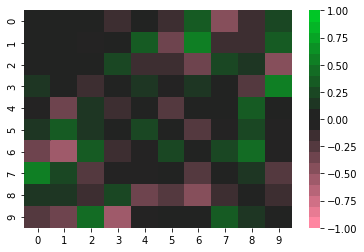

In [11]:
matrix = np.zeros((len(AGENTS), len(AGENTS)))
for i1, A1 in enumerate(AGENTS):
    for i2, A2 in enumerate(AGENTS):
        matrix[i1, i2] = np.mean(A1.reward_by_opponent[A2])
cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")
sns.heatmap(matrix, vmin=-1, vmax=1, cmap=cm)

## Running without training

In [12]:
# our agent
A = AGENTS[0]

# number of games to test for each agent
N_TEST_GAMES = 10

# to track the performance
m_test = Monitor(agents=AGENTS)

# Running training games
for _ in tqdm(range(N_TEST_GAMES)):
    for A2 in AGENTS[1:]:
        A.do_train = False
        A2.do_train = False
        U = Universe(environment=env, agents=[A, A2], monitor=m_test)
        rew = U.episode()
        del U

In [13]:
results = {x: y[AGENTS[0]] for x, y in m_test.stats().items()}

In [14]:
results['action']

[50, 130, 16]

In [15]:
rew = results['reward']

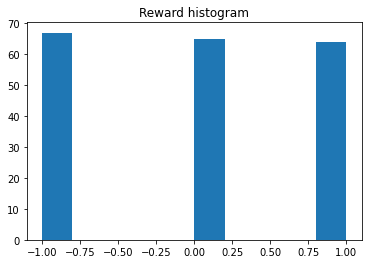

In [16]:
plt.title("Reward histogram")
plt.hist([x for x, y in rew.items() for _ in range(y)])
plt.show()

# Playing with an UNKNOWN opponent

In [17]:
A1 = AGENTS[0]
A2 = np.random.choice(AGENTS[1:])
true_opponent = AGENTS.index(A2)
true_opponent

8

In [18]:
A1.do_train = False
A2.do_train = False

## Identifying threat

In [19]:
# to track the performance
m_estimate = Monitor(agents=AGENTS)

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

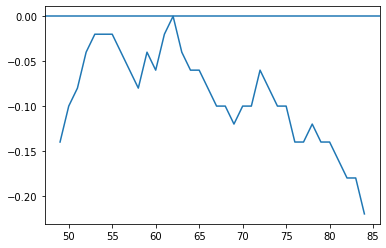

In [20]:
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)

In [23]:
def dict_argmax(d):
    keys = list(d.keys())
    vals = [d[k] for k in keys]
    idx = np.argmax(vals)
    return keys[idx]

agent_logprobs = {A: 0 for A in AGENTS}
for (_, _, (xi, a1, a2, (r1, r2))) in m_estimate.data:
    for A in AGENTS:
        agent_logprobs[A] += np.log(A.model(np.array([xi]))[0][a2].numpy())
estimated_agent = dict_argmax(agent_logprobs)

In [24]:
print("Estimated id %d True id %d" % (estimated_agent.identity, A2.identity))

Estimated id 8 True id 8


### Adversarial training

In [25]:
A1.do_train = True
estimated_agent.do_train = False

In [26]:
U = Universe(environment=env, agents=[A1, estimated_agent], monitor=m_estimate)
for _ in tqdm(range(1000)):
    rew = U.episode()

### Testing time! 

In [27]:
# to track the performance
m_estimate = Monitor(agents=AGENTS)

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

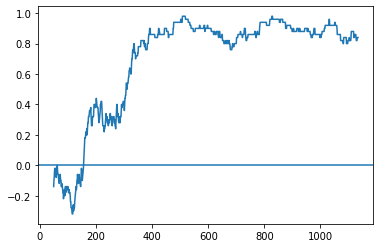

In [28]:
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)